## 章節 7：預測（Prediction）

### 7.8 練習

習題 7.1 ：

如果巴士每20分鐘到站一次，而你到達巴士站的時間是隨機的，你等到公車來的時間從 0 到 20 分為均勻分佈。但實際上公車之間的時間差異很大。假設你在等一輛公車，你也知道過去公車之間的等待時間。計算你等待時間的分佈。


Hint: Suppose that the time between buses is either 5 or 10 minutes with equal
probability. What is the probability that you arrive during one of the 10 minute
intervals? I solve a version of this problem in the next chapter.

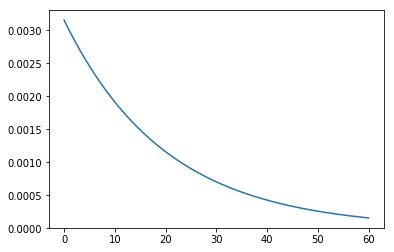

In [22]:
import math
import thinkbayes as tb
import matplotlib.pyplot as plt
import numpy as np

def plot_dist(dist):
    x, y = zip(*sorted(dist.Items()))
    plt.plot(x, y)

    
def EvalExponentialPdf(x, lam):
    return math.exp(-lam*x)


def MakeExponentialPmf(lam, high, n=101):
    pmf = tb.Pmf()
    for x in np.linspace(0, high, n):
        density = EvalExponentialPdf(x, lam)
        pmf.Set(x, density)
    
    pmf.Normalize()
    return pmf

lam = 1/20 # 每分鐘來 1/20 次
prior_pmf = MakeExponentialPmf(lam, 60, n = 1001)
plot_dist(prior_pmf) # 每分鐘的分佈

習題 7.2 ：

假設乘客到達巴士站的情況可以很好的用參數 λ 的泊松過程表達。如果你到公車站候發現有3個人在等候，自從上次公車到達以後，你等待時間的後驗分佈是什麼？

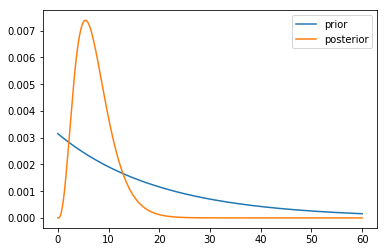

In [26]:
# P(H) 下一輛公車來的時間 ~ Poisson Distribution
# P(D) 看到三個人的機率
# P(D|H) 假設下一輛公車來的時間是第 4 分鐘 那現在看到人來三位的機率是多少？

class BusWait(tb.Suite):
    
    def __init__(self, pmf, people_lam):
        super().__init__(pmf)
        self.people_lam = people_lam
        
    
    def Likelihood(self, data, hypo):
        people, period = data, hypo
        like = self.EvalPoissonPdf(period, people)
        return like
    
    
    def EvalPoissonPdf(self, t, k):
        people_lam = self.people_lam
        return (people_lam*t)**k * math.exp(-people_lam*t) / math.factorial(k)


people_lam = 0.5 # 每分鐘 0.5 人來等車
bus_dist = BusWait(prior_pmf, people_lam)
plot_dist(bus_dist)
bus_dist.Update(3)
plot_dist(bus_dist)
plt.legend(["prior", "posterior"])
plt.show()

習題 7.3：

假設你是一位生態學家，在新環境對昆蟲取樣。你在測試區域部署了 100 個陷阱並且在隔天確認。你發現其中有 37 個陷阱有昆蟲。一但陷阱被驅動，這個陷阱就不能再抓昆蟲了，直到重新設定。

如果你重新設定陷阱並且兩天後回來，你期望多少陷阱被驅動？請計算陷阱驅動數量的後驗預測分佈。

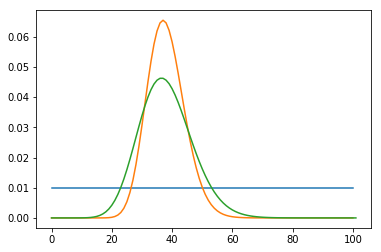

1 days after


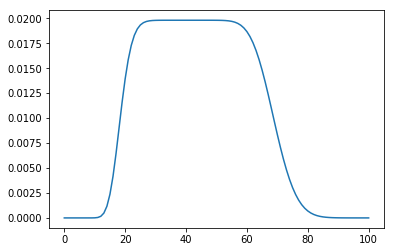

2 days after


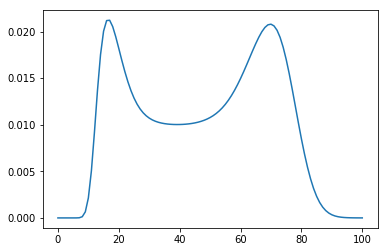

期望兩天後有多少陷阱被驅動 47.51525055035746


In [62]:
# P(H) 陷阱被驅動的平均數量分佈, 幾次 / day
# P(D) 一天發生 x 次驅動
# P(D|H) 假設陷阱平均被驅動 lam=58 次 則下一天發生 x 次驅動的機率

# after Day 1: Make predictive posterior
# after Day 2: Make predictive posterior again

class TrapDist(tb.Suite):
    
    def Likelihood(self, data, hypo):
        lam = hypo
        number_traps = data
        return self.EvalPoissonPdf(number_traps, lam)
    
    
    def EvalPoissonPdf(self, k, lam):
        return (lam)**k * math.exp(-lam) / math.factorial(k)
    
    
    def MakePoissonPmf(self, high, lam):
        pmf = tb.Pmf()
        for i in range(high+1):
            pmf.Set(i, tb.EvalPoissonPmf(i, lam))
    
        pmf.Normalize()
        return pmf
    
    
    def MakePosteriorPredictiveDist(self):
        meta_pmf = tb.Pmf()
        for lam, prob in self.Items():
            for data in range(101):
                posterior = self.Copy()
                posterior.Update(data)
                meta_pmf.Set(posterior, 1) # each data is equal likely
        
        meta_pmf.Normalize()
        return tb.MakeMixture(meta_pmf)
    
        
    
    def MakeBeliefMixture(self):
        meta_pmf = tb.Pmf()
        for lam, prob in self.Items():
            meta_pmf.Set(self.MakePoissonPmf(101, lam), prob)
            
            
        meta_pmf.Normalize()
        return tb.MakeMixture(meta_pmf)
        
        
dist = TrapDist(range(0, 101))
plot_dist(dist)
dist.Update(37)
plot_dist(dist)

mix = dist.MakeBeliefMixture() # likelihood 
plot_dist(mix)
plt.show()


for i in range(1, 3): # number of days after
    
    mix_post = dist.MakePosteriorPredictiveDist()
    dist.SetDict(mix_post.GetDict())
    print(i, "days after")
    plot_dist(dist)
    plt.show()

print("期望兩天後有多少陷阱被驅動", dist.Mean())

習題 7.4：

假設你是管理公寓大樓公共區域的 100 個燈泡。你的職責是當燈泡壞了，更換燈泡。

1月1號的時候 100 個燈泡都正常。當你2月1號檢查時，有3個燈泡壞了。如果你在4月1號再檢查，你估計有多少燈泡壞掉？

在前面的練習，你有道理假設每次事件發生的機率是不隨時間改變的。但是燈泡壞掉的似然性是跟使用時間有關。具體來說，老鄧砲由於燈絲的蒸發而增加故障的機率。

這是一個開放的問題；你將需要做建模決策。你可能想要閱讀 Weibull 分佈的資料：https://en.wikipedia.org/wiki/Weibull_distribution

或是你想閱讀燈泡生存曲線（light bulb survival curves）的相關資料。